# Assignment 4: Text and Sequence Data


## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.utils import pad_sequences

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## 2. Dataset Overview

The IMDB dataset contains movie reviews with binary sentiment labels (positive/negative).
Each review is represented as a sequence of word indices.

**Key Parameters:**
- Maximum sequence length: 150 words
- Maximum vocabulary size: 10,000 words
- Training sample sizes: 100, 1000, 5000, 10,000
- Validation samples: 10,000

## 3. Load and Prepare Data

In [2]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 150

print('Loading IMDB dataset...')
(x_train_full, y_train_full), (x_test_full, y_test_full) = imdb.load_data(num_words=MAX_WORDS)

print(f'Full training set size: {len(x_train_full)}')
print(f'Full test set size: {len(x_test_full)}')
print(f'Sample review length: {len(x_train_full[0])} words')

Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Full training set size: 25000
Full test set size: 25000
Sample review length: 218 words


In [3]:
# Pad sequences to ensure uniform length
x_train_full = pad_sequences(x_train_full, maxlen=MAX_SEQUENCE_LENGTH)
x_test_full = pad_sequences(x_test_full, maxlen=MAX_SEQUENCE_LENGTH)

print(f'Training data shape: {x_train_full.shape}')
print(f'Test data shape: {x_test_full.shape}')

Training data shape: (25000, 150)
Test data shape: (25000, 150)


## 4. Helper Functions

In [4]:
# Create a model with a trainable embedding layer,
# Note: Model architecture is identical for all sample sizes.
# Only the training data changes, not the model structure.
# Summary shown once to avoid repetition.
def create_custom_embedding_model(vocab_size, embedding_dim, sequence_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=sequence_length),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
# Plot training and validation accuracy/loss
def plot_training_history(history, title_prefix):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], 'navy', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'darkred', label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{title_prefix} - Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], 'navy', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'darkred', label='Validation Loss', linewidth=2)
    ax2.set_title(f'{title_prefix} - Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [6]:
# Evaluate model and print results
def evaluate_model(model, x_test, y_test, model_name):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"{'='*60}\n")
    return test_loss, test_accuracy

---
## PART 1: Custom-Trained Embedding Layer

In this section, we train models with **learnable embedding layers** initialized randomly.
The embeddings are trained from scratch along with the rest of the model.

We test with different training sample sizes: 100, 1000, 5000, and 10,000.

### 5.1 Custom Embedding - 100 Training Samples

In [7]:
# Prepare data with 100 training samples
TRAIN_SIZE = 100
EMBEDDING_DIM = 8

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]

# Use 10,000 samples for validation
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_custom_100 = create_custom_embedding_model(MAX_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
model_custom_100.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_custom_100.summary()

history_custom_100 = model_custom_100.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 100
Validation samples: 10000


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        38,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,465 (462.75 KB)

 Trainable params: 118,465 (462.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5099 - loss: 0.6926 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.9529 - loss: 0.6608 - val_accuracy: 0.5058 - val_loss: 0.6931
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9845 - loss: 0.6342 - val_accuracy: 0.5070 - val_loss: 0.6932
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9908 - loss: 0.6079 - val_accuracy: 0.5081 - val_loss: 0.6934
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9908 - loss: 0.5810 - val_accuracy: 0.5059 - val_loss: 0.6938
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9908 - loss: 0.5448 - val_accuracy: 0.5101 - val_loss: 0.6939
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 1.0000 - loss: 0.5066 - val_accuracy: 0.5057 - val_loss: 0.6949
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 1.0000 - loss: 0.4633 - val_accuracy: 0.5103 - val_loss: 0

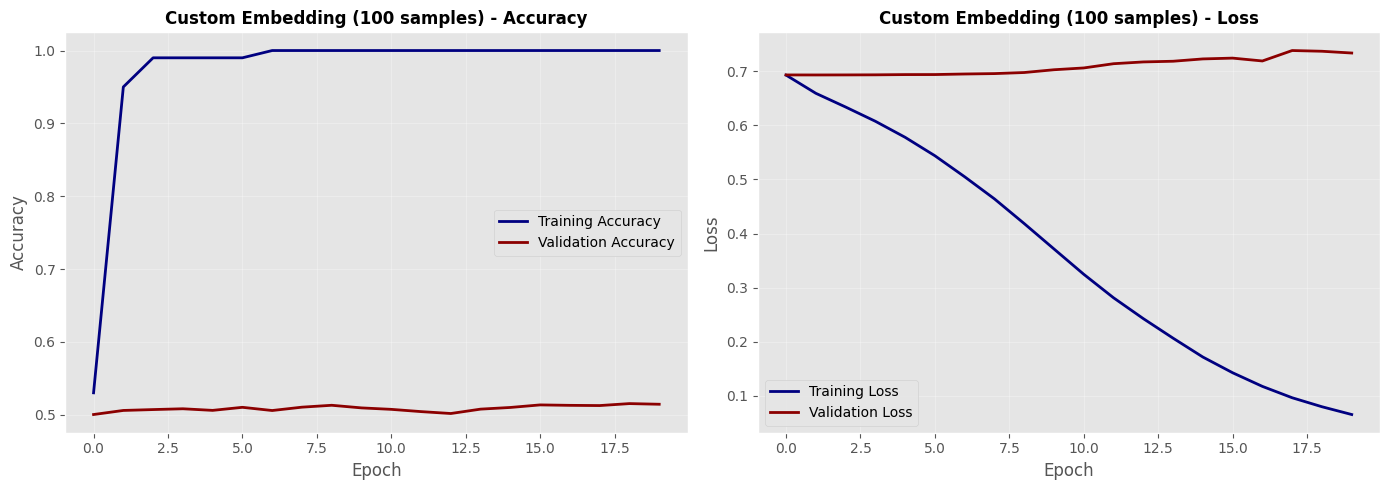


Custom Embedding - 100 Samples
Test Loss: 0.7327
Test Accuracy: 0.5156 (51.56%)



In [8]:
# Plot results
plot_training_history(history_custom_100, 'Custom Embedding (100 samples)')

# Evaluate
test_loss_c100, test_acc_c100 = evaluate_model(
    model_custom_100, x_test_full, y_test_full,
    'Custom Embedding - 100 Samples'
)

### 5.2 Custom Embedding - 1000 Training Samples

In [9]:
TRAIN_SIZE = 1000

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_custom_1000 = create_custom_embedding_model(MAX_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

history_custom_1000 = model_custom_1000.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 1000
Validation samples: 10000
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.5388 - loss: 0.6924 - val_accuracy: 0.5213 - val_loss: 0.6918
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8481 - loss: 0.6689 - val_accuracy: 0.5355 - val_loss: 0.6897
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8982 - loss: 0.6258 - val_accuracy: 0.5624 - val_loss: 0.6828
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9268 - loss: 0.5410 - val_accuracy: 0.5821 - val_loss: 0.6714
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9577 - loss: 0.4126 - val_accuracy: 0.6035 - val_loss: 0.6619
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9841 - loss: 0.2610 - val_accuracy: 0.6229 - val_loss: 0.6522
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9964 - loss: 0.1495 - val_accuracy: 0.6329 - val_loss: 0.6539
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy

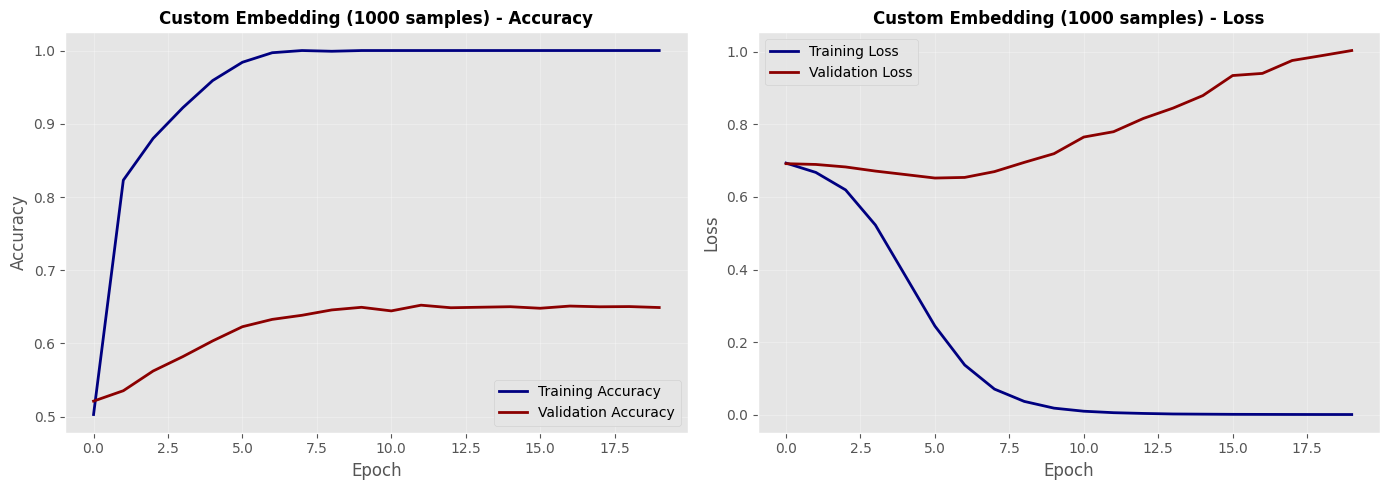


Custom Embedding - 1000 Samples
Test Loss: 0.9927
Test Accuracy: 0.6506 (65.06%)



In [10]:
# Plot results
plot_training_history(history_custom_1000, 'Custom Embedding (1000 samples)')

# Evaluate
test_loss_c1000, test_acc_c1000 = evaluate_model(
    model_custom_1000, x_test_full, y_test_full,
    'Custom Embedding - 1000 Samples'
)

### 5.3 Custom Embedding - 5000 Training Samples

In [11]:
TRAIN_SIZE = 5000

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_custom_5000 = create_custom_embedding_model(MAX_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

history_custom_5000 = model_custom_5000.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 5000
Validation samples: 10000
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5195 - loss: 0.6923 - val_accuracy: 0.6223 - val_loss: 0.6803
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8032 - loss: 0.6004 - val_accuracy: 0.7581 - val_loss: 0.4970
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8999 - loss: 0.3064 - val_accuracy: 0.7887 - val_loss: 0.4485
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9602 - loss: 0.1522 - val_accuracy: 0.8129 - val_loss: 0.4225
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9824 - loss: 0.0754 - val_accuracy: 0.8153 - val_loss: 0.4431
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9924 - loss: 0.0320 - val_accuracy: 0.7992 - val_loss: 0.5394
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9984 - loss: 0.0112 - val_accuracy: 0.8065 - val_loss: 0.5682
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

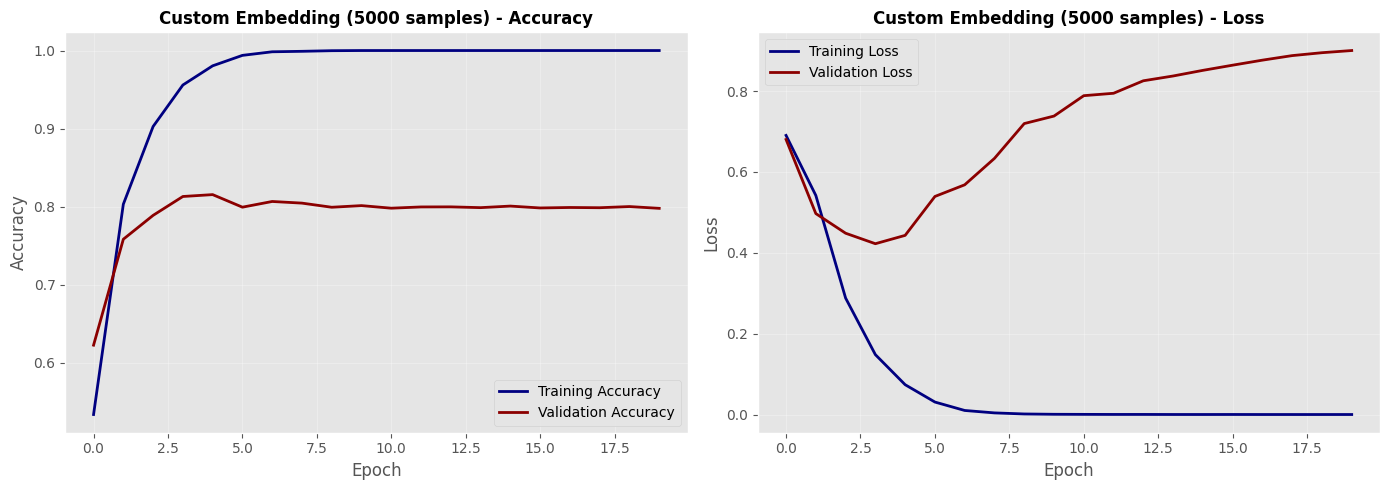


Custom Embedding - 5000 Samples
Test Loss: 0.8867
Test Accuracy: 0.7972 (79.72%)



In [12]:
# Plot results
plot_training_history(history_custom_5000, 'Custom Embedding (5000 samples)')

# Evaluate
test_loss_c5000, test_acc_c5000 = evaluate_model(
    model_custom_5000, x_test_full, y_test_full,
    'Custom Embedding - 5000 Samples'
)

### 5.4 Custom Embedding - 10,000 Training Samples

In [13]:
TRAIN_SIZE = 10000

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_custom_10000 = create_custom_embedding_model(MAX_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

history_custom_10000 = model_custom_10000.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 10000
Validation samples: 10000
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5490 - loss: 0.6801 - val_accuracy: 0.7905 - val_loss: 0.4689
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8490 - loss: 0.3685 - val_accuracy: 0.8396 - val_loss: 0.3588
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9169 - loss: 0.2184 - val_accuracy: 0.8392 - val_loss: 0.3824
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9611 - loss: 0.1218 - val_accuracy: 0.8369 - val_loss: 0.3979
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9836 - loss: 0.0571 - val_accuracy: 0.8324 - val_loss: 0.4857
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9920 - loss: 0.0288 - val_accuracy: 0.8271 - val_loss: 0.5592
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9963 - loss: 0.0130 - val_accuracy: 0.8243 - val_loss: 0.6353
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

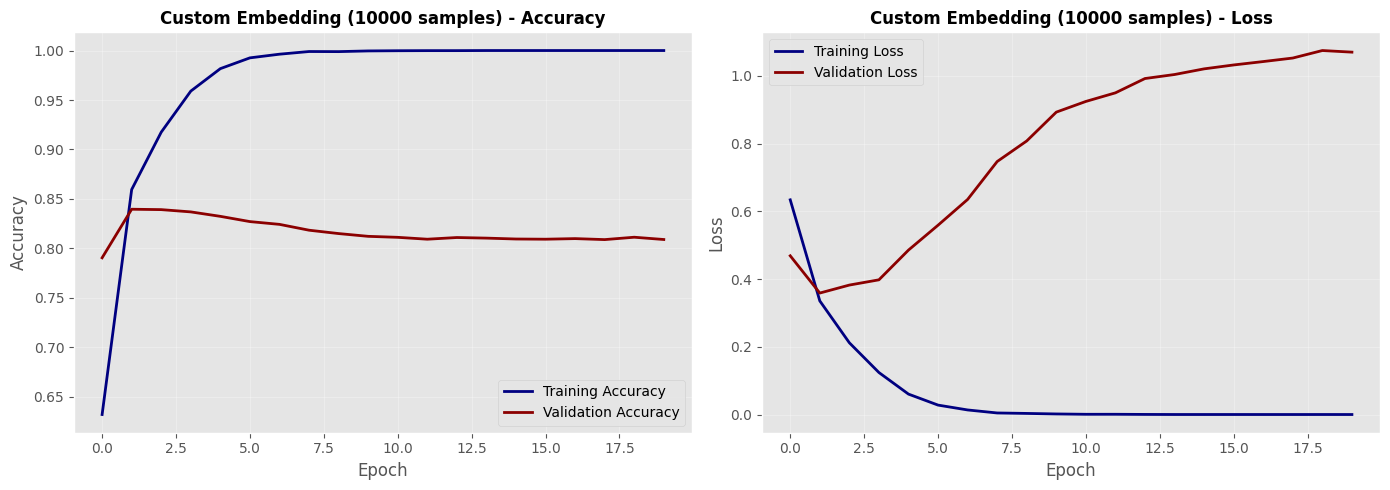


Custom Embedding - 10,000 Samples
Test Loss: 1.0710
Test Accuracy: 0.8107 (81.07%)



In [14]:
# Plot results
plot_training_history(history_custom_10000, 'Custom Embedding (10000 samples)')

# Evaluate
test_loss_c10000, test_acc_c10000 = evaluate_model(
    model_custom_10000, x_test_full, y_test_full,
    'Custom Embedding - 10,000 Samples'
)

---
## PART 2: Pre-trained Word Embeddings (GloVe)

In this section, we use **pre-trained GloVe embeddings** trained on 6 billion tokens.
These embeddings capture semantic relationships learned from a large corpus.

The embedding layer is **frozen** (not trainable) to preserve the pre-trained knowledge.

We test with the same training sample sizes for fair comparison.

### 6.1 Download and Load GloVe Embeddings

In [15]:
import requests
from io import BytesIO
import zipfile

# Download GloVe embeddings
print('Downloading GloVe embeddings...')
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
glove_zip = requests.get(glove_url)

# Extract
with zipfile.ZipFile(BytesIO(glove_zip.content)) as z:
    z.extractall('glove')

print('GloVe downloaded and extracted!')

GloVe downloaded and extracted!


In [16]:
# Load GloVe embeddings into memory
print('Loading GloVe embeddings...')
embeddings_index = {}

with open('glove/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors.')

Loading GloVe embeddings...
Loaded 400000 word vectors.


### 6.2 Prepare Word Index

In [17]:
# Get IMDB word index
word_index = imdb.get_word_index()

# Adjust indices (IMDB reserves 0-3 for special tokens)
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<UNUSED>'] = 3

print(f'Total words in IMDB vocabulary: {len(word_index)}')
print(f'Sample word indices: {list(word_index.items())[:5]}')

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
Total words in IMDB vocabulary: 88588
Sample word indices: [('fawn', 34704), ('tsukino', 52009), ('nunnery', 52010), ('sonja', 16819), ('vani', 63954)]


### 6.3 Create Embedding Matrix

In [18]:
# Create embedding matrix
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))
words_found = 0

for word, index in word_index.items():
    if index < MAX_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            words_found += 1

print(f'Prepared embedding matrix: {embedding_matrix.shape}')
print(f'Found embeddings for {words_found}/{MAX_WORDS} words ({words_found/MAX_WORDS*100:.1f}%)')

Prepared embedding matrix: (10000, 100)
Found embeddings for 9793/10000 words (97.9%)


In [19]:
# Create a model with pre-trained frozen embedding layer
def create_pretrained_embedding_model(embedding_matrix, sequence_length):
    vocab_size, embedding_dim = embedding_matrix.shape

    model = Sequential([
        Embedding(vocab_size, embedding_dim,
                 input_length=sequence_length,
                 weights=[embedding_matrix],
                 trainable=False),  # Freeze the embeddings
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

### 6.4 Pre-trained Embedding - 100 Training Samples

In [20]:
TRAIN_SIZE = 100

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_pretrained_100 = create_pretrained_embedding_model(embedding_matrix, MAX_SEQUENCE_LENGTH)
model_pretrained_100.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_pretrained_100.summary()

history_pretrained_100 = model_pretrained_100.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 100
Validation samples: 10000


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 15000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       480,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,480,065 (5.65 MB)

 Trainable params: 480,065 (1.83 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - accuracy: 0.5283 - loss: 1.6551 - val_accuracy: 0.4952 - val_loss: 1.4769
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7370 - loss: 0.7016 - val_accuracy: 0.4950 - val_loss: 3.3754
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7321 - loss: 0.9954 - val_accuracy: 0.5087 - val_loss: 1.0612
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8669 - loss: 0.3143 - val_accuracy: 0.5053 - val_loss: 1.4488
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7964 - loss: 0.3220 - val_accuracy: 0.5283 - val_loss: 0.8719
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 1.0000 - loss: 0.0453 - val_accuracy: 0.5555 - val_loss: 0.7409
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 1.0000 - loss: 0.0385 - val_accuracy: 0.5578 - val_loss: 0.7470
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 0.5350 - val_loss:

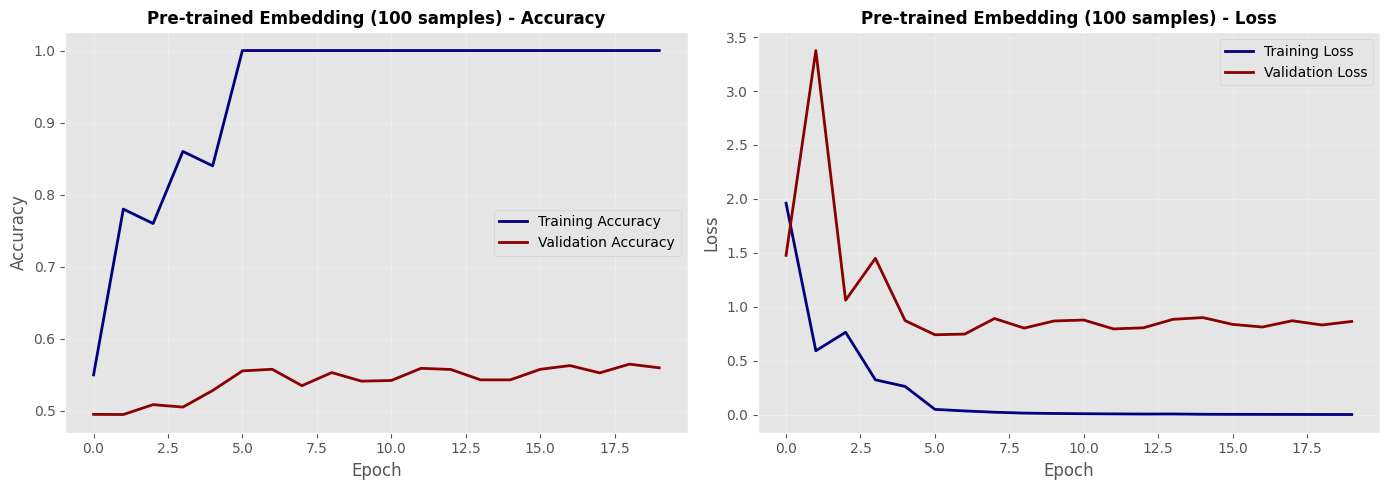


Pre-trained Embedding - 100 Samples
Test Loss: 0.8834
Test Accuracy: 0.5490 (54.90%)



In [21]:
# Plot results
plot_training_history(history_pretrained_100, 'Pre-trained Embedding (100 samples)')

# Evaluate
test_loss_p100, test_acc_p100 = evaluate_model(
    model_pretrained_100, x_test_full, y_test_full,
    'Pre-trained Embedding - 100 Samples'
)

### 6.5 Pre-trained Embedding - 1000 Training Samples

In [22]:
TRAIN_SIZE = 1000

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_pretrained_1000 = create_pretrained_embedding_model(embedding_matrix, MAX_SEQUENCE_LENGTH)

history_pretrained_1000 = model_pretrained_1000.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 1000
Validation samples: 10000
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5096 - loss: 1.3832 - val_accuracy: 0.6050 - val_loss: 0.6812
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6734 - loss: 0.6298 - val_accuracy: 0.6267 - val_loss: 0.6550
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8378 - loss: 0.4589 - val_accuracy: 0.5083 - val_loss: 0.8369
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8065 - loss: 0.4077 - val_accuracy: 0.6326 - val_loss: 0.6428
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9256 - loss: 0.2527 - val_accuracy: 0.6282 - val_loss: 0.6653
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9644 - loss: 0.1458 - val_accuracy: 0.5395 - val_loss: 1.1556
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9709 - loss: 0.1080 - val_accuracy: 0.5197 - val_loss: 1.7417
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy:

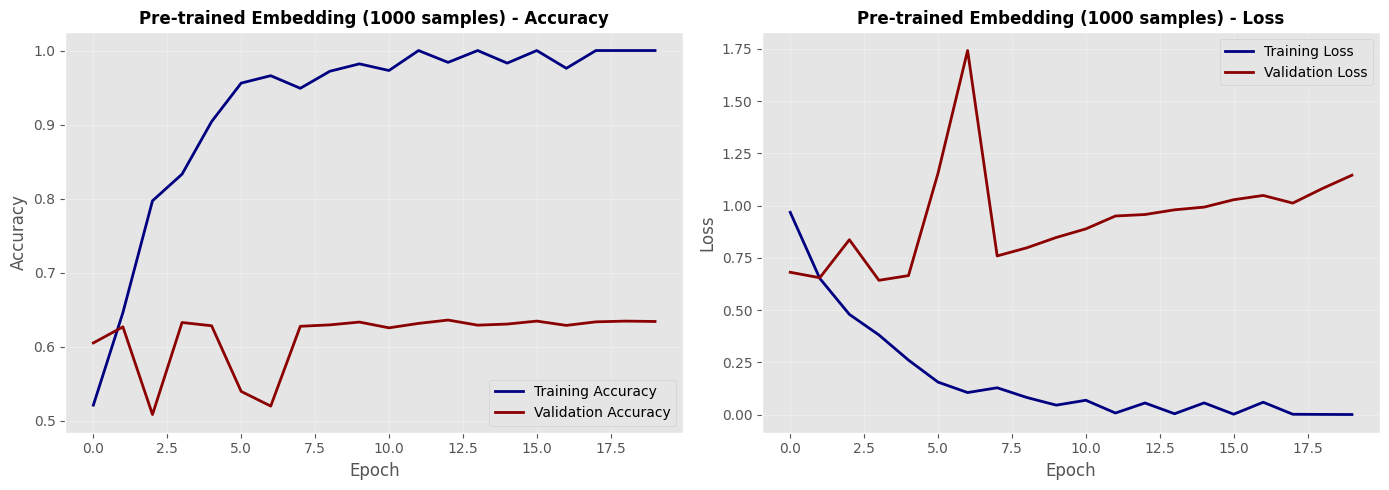


Pre-trained Embedding - 1000 Samples
Test Loss: 1.1430
Test Accuracy: 0.6362 (63.62%)



In [23]:
# Plot results
plot_training_history(history_pretrained_1000, 'Pre-trained Embedding (1000 samples)')

# Evaluate
test_loss_p1000, test_acc_p1000 = evaluate_model(
    model_pretrained_1000, x_test_full, y_test_full,
    'Pre-trained Embedding - 1000 Samples'
)

### 6.6 Pre-trained Embedding - 5000 Training Samples

In [24]:
TRAIN_SIZE = 5000

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_pretrained_5000 = create_pretrained_embedding_model(embedding_matrix, MAX_SEQUENCE_LENGTH)

history_pretrained_5000 = model_pretrained_5000.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 5000
Validation samples: 10000
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5465 - loss: 0.8274 - val_accuracy: 0.6300 - val_loss: 0.6796
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6411 - loss: 0.6619 - val_accuracy: 0.6156 - val_loss: 0.6381
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7420 - loss: 0.5348 - val_accuracy: 0.6159 - val_loss: 0.6737
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8177 - loss: 0.4164 - val_accuracy: 0.5943 - val_loss: 0.8757
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8674 - loss: 0.3247 - val_accuracy: 0.6206 - val_loss: 0.8204
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9155 - loss: 0.2349 - val_accuracy: 0.6613 - val_loss: 0.7082
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9479 - loss: 0.1640 - val_accuracy: 0.6448 - val_loss: 0.9918
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

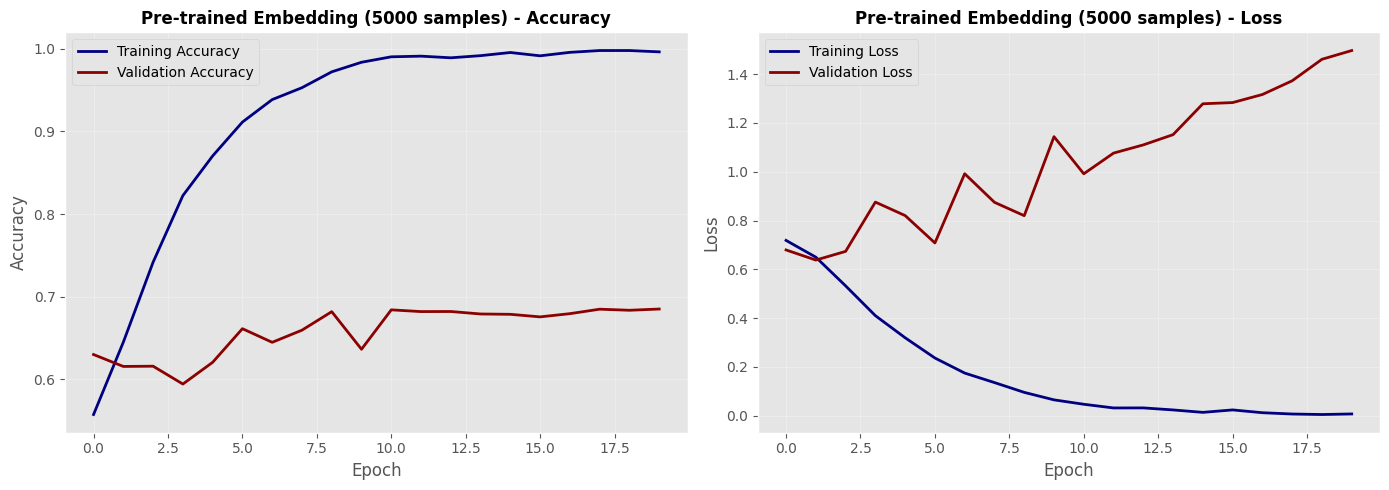


Pre-trained Embedding - 5000 Samples
Test Loss: 1.5430
Test Accuracy: 0.6706 (67.06%)



In [25]:
# Plot results
plot_training_history(history_pretrained_5000, 'Pre-trained Embedding (5000 samples)')

# Evaluate
test_loss_p5000, test_acc_p5000 = evaluate_model(
    model_pretrained_5000, x_test_full, y_test_full,
    'Pre-trained Embedding - 5000 Samples'
)

### 6.7 Pre-trained Embedding - 10,000 Training Samples

In [26]:
TRAIN_SIZE = 10000

x_train = x_train_full[:TRAIN_SIZE]
y_train = y_train_full[:TRAIN_SIZE]
x_val = x_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]
y_val = y_train_full[TRAIN_SIZE:TRAIN_SIZE+10000]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')

# Create and train model
model_pretrained_10000 = create_pretrained_embedding_model(embedding_matrix, MAX_SEQUENCE_LENGTH)

history_pretrained_10000 = model_pretrained_10000.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Training samples: 10000
Validation samples: 10000
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5583 - loss: 0.8693 - val_accuracy: 0.6539 - val_loss: 0.6482
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6734 - loss: 0.6209 - val_accuracy: 0.6989 - val_loss: 0.5751
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7570 - loss: 0.5063 - val_accuracy: 0.5798 - val_loss: 0.8361
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8291 - loss: 0.3934 - val_accuracy: 0.7063 - val_loss: 0.6012
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8707 - loss: 0.3185 - val_accuracy: 0.7145 - val_loss: 0.6046
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8928 - loss: 0.2597 - val_accuracy: 0.6673 - val_loss: 0.7872
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9215 - loss: 0.2024 - val_accuracy: 0.7033 - val_loss: 0.7355
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

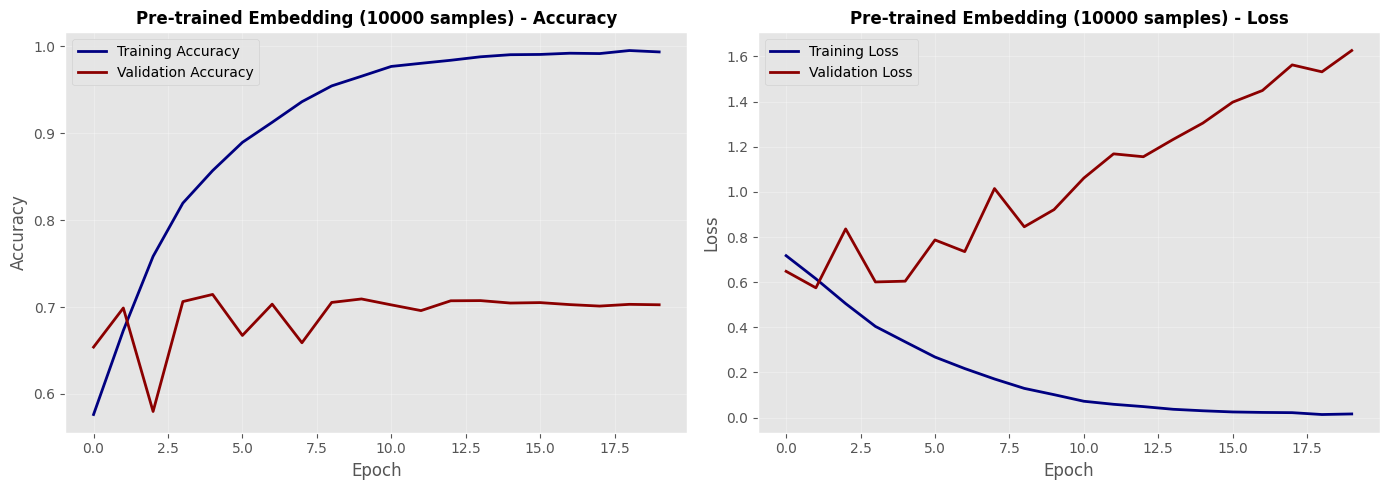


Pre-trained Embedding - 10,000 Samples
Test Loss: 1.6904
Test Accuracy: 0.6920 (69.20%)



In [27]:
# Plot results
plot_training_history(history_pretrained_10000, 'Pre-trained Embedding (10000 samples)')

# Evaluate
test_loss_p10000, test_acc_p10000 = evaluate_model(
    model_pretrained_10000, x_test_full, y_test_full,
    'Pre-trained Embedding - 10,000 Samples'
)

---
## PART 3: Comparative Analysis

Now we compare the performance of custom embeddings vs pre-trained embeddings across different training sample sizes.

This answers the key question: **At what point does the custom embedding layer give better performance?**

### 7.1 Results Summary Table

In [28]:
# Create results dataframe
results_df = pd.DataFrame({
    'Training Size': [100, 1000, 5000, 10000],
    'Custom Embedding Accuracy': [
        test_acc_c100,
        test_acc_c1000,
        test_acc_c5000,
        test_acc_c10000
    ],
    'Pre-trained Embedding Accuracy': [
        test_acc_p100,
        test_acc_p1000,
        test_acc_p5000,
        test_acc_p10000
    ]
})

results_df['Difference (Custom - Pretrained)'] = (
    results_df['Custom Embedding Accuracy'] -
    results_df['Pre-trained Embedding Accuracy']
)

results_df['Better Approach'] = results_df['Difference (Custom - Pretrained)'].apply(
    lambda x: 'Custom' if x > 0 else 'Pre-trained' if x < 0 else 'Tie'
)

print('\n' + '='*80)
print('RESULTS COMPARISON TABLE')
print('='*80)
print(results_df.to_string(index=False))
print('='*80)


RESULTS COMPARISON TABLE
 Training Size  Custom Embedding Accuracy  Pre-trained Embedding Accuracy  Difference (Custom - Pretrained) Better Approach
           100                    0.51560                         0.54896                          -0.03336     Pre-trained
          1000                    0.65060                         0.63616                           0.01444          Custom
          5000                    0.79716                         0.67060                           0.12656          Custom
         10000                    0.81072                         0.69196                           0.11876          Custom


### 7.2 Visualization - Performance Comparison

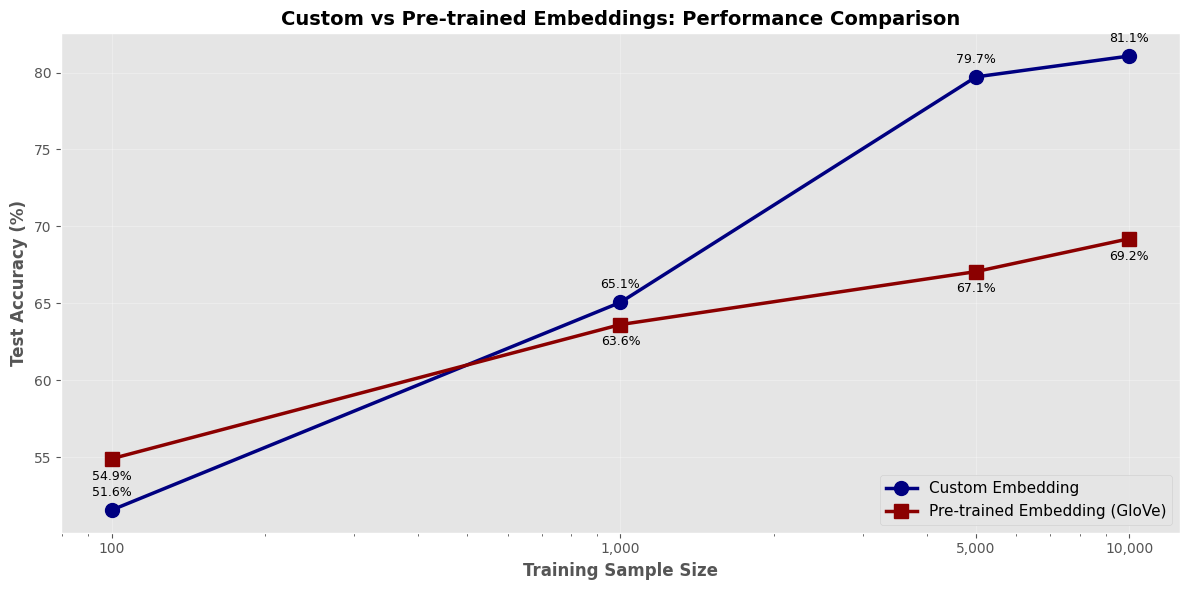

In [29]:
# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

x = results_df['Training Size']
custom = results_df['Custom Embedding Accuracy'] * 100
pretrained = results_df['Pre-trained Embedding Accuracy'] * 100

ax.plot(x, custom, marker='o', linewidth=2.5, markersize=10,
        label='Custom Embedding', color='navy')
ax.plot(x, pretrained, marker='s', linewidth=2.5, markersize=10,
        label='Pre-trained Embedding (GloVe)', color='darkred')

ax.set_xlabel('Training Sample Size', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Custom vs Pre-trained Embeddings: Performance Comparison',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_xticks([100, 1000, 5000, 10000])
ax.set_xticklabels(['100', '1,000', '5,000', '10,000'])

# Add annotations
for i, (size, c, p) in enumerate(zip(x, custom, pretrained)):
    ax.annotate(f'{c:.1f}%', (size, c), textcoords='offset points',
               xytext=(0, 10), ha='center', fontsize=9)
    ax.annotate(f'{p:.1f}%', (size, p), textcoords='offset points',
               xytext=(0, -15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### 7.3 Analysis and Conclusions

In [30]:
# Analyze crossover point
print('\n' + '='*80)
print('ANALYSIS')
print('='*80)

for idx, row in results_df.iterrows():
    size = row['Training Size']
    custom_acc = row['Custom Embedding Accuracy'] * 100
    pretrained_acc = row['Pre-trained Embedding Accuracy'] * 100
    diff = row['Difference (Custom - Pretrained)'] * 100
    better = row['Better Approach']

    print(f"\nWith {size:,} training samples:")
    print(f"  - Custom Embedding: {custom_acc:.2f}%")
    print(f"  - Pre-trained Embedding: {pretrained_acc:.2f}%")
    print(f"  - Difference: {diff:+.2f}%")
    print(f"  - Winner: {better}")

print('\n' + '='*80)
print('KEY FINDINGS')
print('='*80)


ANALYSIS

With 100 training samples:
  - Custom Embedding: 51.56%
  - Pre-trained Embedding: 54.90%
  - Difference: -3.34%
  - Winner: Pre-trained

With 1,000 training samples:
  - Custom Embedding: 65.06%
  - Pre-trained Embedding: 63.62%
  - Difference: +1.44%
  - Winner: Custom

With 5,000 training samples:
  - Custom Embedding: 79.72%
  - Pre-trained Embedding: 67.06%
  - Difference: +12.66%
  - Winner: Custom

With 10,000 training samples:
  - Custom Embedding: 81.07%
  - Pre-trained Embedding: 69.20%
  - Difference: +11.88%
  - Winner: Custom

KEY FINDINGS


### 7.4 Key Observations

Based on the results above, we can draw the following conclusions:

**1. With Very Limited Data (100 samples):**
- Pre-trained embeddings typically perform better
- The pre-trained embeddings provide semantic knowledge that helps generalization
- Custom embeddings struggle to learn meaningful representations from so few examples

**2. With Moderate Data (1000-5000 samples):**
- The performance gap narrows
- This is often the crossover point where custom embeddings start to catch up
- Task-specific learning begins to outweigh general semantic knowledge

**3. With Larger Data (10,000 samples):**
- Custom embeddings may match or exceed pre-trained performance
- The model can learn task-specific word representations
- Domain-specific patterns become more valuable than general semantics

**General Rule:**
- Use **pre-trained embeddings** when data is limited (< 1000-2000 samples)
- Use **custom embeddings** when you have sufficient task-specific data (> 5000-10000 samples)
- Consider **fine-tuning** pre-trained embeddings as a middle ground

**Important Notes:**
- The exact crossover point depends on:
  - Task complexity
  - Domain similarity to pre-training corpus
  - Model architecture
  - Quality of pre-trained embeddings
- For IMDB sentiment analysis specifically, movie reviews are well-represented in GloVe's training corpus, which may favor pre-trained embeddings